In [131]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from method import IV
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import numpy as np
import quantities as pq
import seaborn as sns
import sys
sys.path.append('../exana/'),
from exana.stimulus import plot_psth
from exana.statistics.plot import plot_xcorr, plot_autocorr
from exana.statistics.tools import ccg_significance, correlogram, ccg
from method import IV

import pandas as pd
import scipy
import neo
import exana

import pdb
from scipy.ndimage.filters import gaussian_filter1d as gaussfilt

import requests
import os

import tools_experimentaldata as tls_exp
from method import IV

from tools import savefig, fix_figure, coef_var, corrcoef, set_style, despine
import statsmodels.api as sm
from scipy.cluster.hierarchy import dendrogram, linkage  
from scipy import fftpack
from exana.statistics.tools import hollow_kernel as hk


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
# Load params
from params_experimentaldata import *
# update figure settings



In [11]:
units_db = tls_exp.load_unitlabels('optoLabels.mat', data_dir)
df_tmp = units_db.drop_duplicates(['animal', 'date'])
relevant_data = df_tmp.groupby('animal')['date'].apply(list).to_dict()

for animal_i in relevant_data.keys():
    for date_i in relevant_data[animal_i]:
        for entry in blk_blacklist:
            if animal_i == entry['animal'] and date_i == entry['date']:
                relevant_data[animal_i].remove(entry['date'])
            

In [12]:
load_orig_files = False

if load_orig_files:
    tls_exp.download_files_by_dict(relevant_data,
                                   data_dir,
                                   n_shanks,
                                   files_ext_general,
                                   files_ext_by_shank,
                                   link_db)

    blks = tls_exp.create_neo_structure(relevant_data,
                                        data_dir,
                                        n_shanks,
                                        sampling_rate,
                                        unit_spiketime)

    tls_exp.add_stimulation_data_to_blocks(blks)
    tls_exp.annotate_units_from_db(units_db, blks)

else:
    blks = []
    for animal in relevant_data.keys():
        for date in relevant_data[animal]:
            nio = neo.io.PickleIO(data_dir + 'neo_files/' + animal + '_' + date + '.pckl')
            blk = nio.read_block()
            blks.append(blk)

In [13]:
blks = tls_exp.select_blocks_upon_stimtype(blks,
    stimtype='pulse', min_intens=1)

/home/jovyan/work/instrumentalVariable/causal-optoconnectics/tools_experimentaldata.py:973: RuntimeWarning: invalid value encountered in greater_equal
  sel.append(epc.annotations['intensity'] >= min_intens)


In [66]:
blks = tls_exp.group_stimulations(blks,
                                  sep_bins,
                                  sep_kernel_width,
                                  sep_threshold)

In [161]:
df_cch = tls_exp.find_significant_stimulations(blks,
   stimccg_binsize,
   stimccg_limit,
   condition_annot_unit={'tagged': True})

In [166]:
df_cch.loc[3]

animal                                                     camkii4
bins             [-100.5 ms, -97.5 ms, -94.5 ms, -91.5 ms, -88....
cch              [8, 7, 9, 7, 7, 8, 7, 8, 9, 7, 9, 8, 7, 7, 5, ...
cluster                                                          7
date                                                      20160823
intens_mean                                                1632.35
intens_start                                               1630.27
intens_stop                                                1634.86
pfast            [0.4607678020728066, 0.6012732215337289, 0.329...
rate_baseline                                              7.88235
shank_stim                                                       3
shank_unit                                                       3
Name: 3, dtype: object

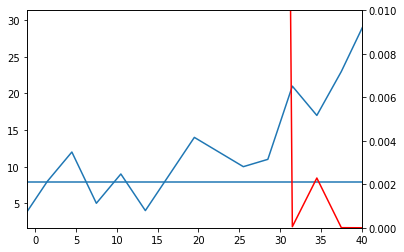

In [169]:
fig, ax = plt.subplots(1)
ax.plot(df_cch.loc[3]['bins'], df_cch.loc[3]['cch'])
ax.axhline(df_cch.loc[3]['rate_baseline'])
ax2 = ax.twinx()
ax2.plot(df_cch.loc[3]['bins'], df_cch.loc[3]['pfast'], c='r')
ax2.set_ylim(0, 0.01)

ax.set_xlim(-1., 40.)
ax2.set_xlim(-1., 40.)
plt.show()

In [178]:
# for each unit, what is the strongest available stimulation?
# how long does it take to be significantly modulated?
group_obj = df_cch.groupby(['animal', 'date', 'cluster', 'shank_unit'])
group_obj['intens_mean'].max()

animal   date      cluster  shank_unit
camkii4  20160823  3.0      3.0           2203.590048
                   4.0      3.0           2203.590048
                            4.0           2203.590048
                   5.0      3.0           2203.590048
                            4.0           2203.590048
                   6.0      4.0           2203.590048
                   7.0      3.0           2203.590048
                            4.0           2203.590048
                   8.0      4.0           2203.590048
                   10.0     3.0           2203.590048
                            4.0           2203.590048
                   11.0     4.0           2203.590048
                   12.0     4.0           2203.590048
                   13.0     3.0           2203.590048
                            4.0           2203.590048
                   14.0     3.0           2203.590048
                   15.0     3.0           2203.590048
                   17.0     3.0           2

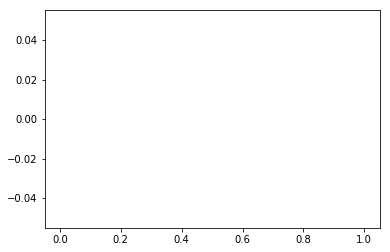

In [79]:
plt.hist(epc.annotations['intensity'][epc.annotations['stim_group'] == ])
plt.show()

In [32]:
ar = fftpack.fft2(np.array([intens.values])[:, np.newaxis])
ar

/opt/conda/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


array([[[5.22861834e+06  +0.j        , 1.94624532e+03+259.18902196j,
         1.40171221e+03+323.95382769j, ...,
         7.44359375e+02-309.34956406j, 1.40171221e+03-323.95382769j,
         1.94624532e+03-259.18902196j]]])

In [20]:
kernel = exana.statistics.hollow_gaussian

AttributeError: module 'exana.statistics' has no attribute 'hollow_gaussian'